In [1]:
import tensorflow as tf
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from os import path
import shutil
from keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa



dtype = torch.float
device = torch.device("cpu")

In [2]:
tf.__version__

'2.8.0'

In [3]:

#src = "chest_xray/train/PNEUMONIA"
#dst1 = "chest_xray/train/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/train/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)


In [4]:
#src = "chest_xray/test/PNEUMONIA"
#dst1 = "chest_xray/test/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/test/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)

In [5]:
data_dir = './chest_xray/train'
img_height = 180
img_width = 180
batchSize = 64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height,img_width),
                                                       batch_size=batchSize
                                                      )


Found 5232 files belonging to 3 classes.
Using 4186 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batchSize)

Found 5232 files belonging to 3 classes.
Using 1046 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRUS']


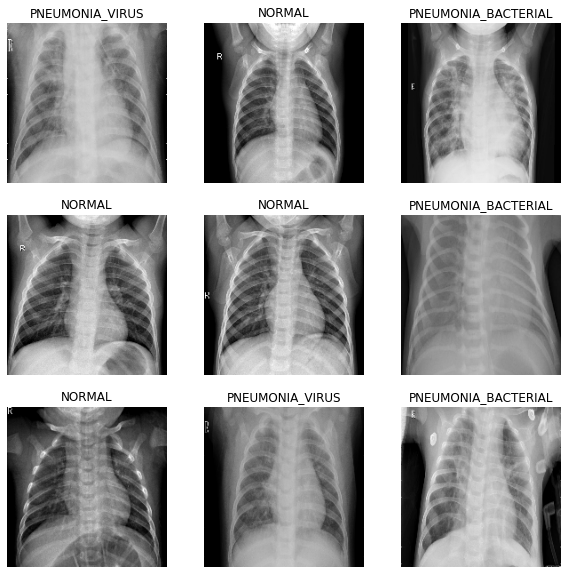

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(200).prefetch(buffer_size=AUTOTUNE)

In [11]:
#normalization_layer = layers.Rescaling(1./255)

In [12]:
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))#
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [13]:
data_augmentation = keras.Sequential(
  [
    #layers.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
  ]
)

In [14]:
num_classes = len(class_names)

model = Sequential([
   data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2DTranspose(64, 3, strides=3, padding='same'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [17]:
#tf.config.set_soft_device_placement(True) 
with tf.device('/cpu:0'):   
    epochs=100
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
#sess = tf.Session(config=tf.ConfigProto(
 #     allow_soft_placement=True, log_device_placement=True))

#print(sess.run(history))

Epoch 1/100
66/66 [==============================] - 46s 616ms/step - loss: 0.9773 - accuracy: 0.6037 - val_loss: 1.5942 - val_accuracy: 0.5019
Epoch 2/100
66/66 [==============================] - 39s 597ms/step - loss: 0.7333 - accuracy: 0.6801 - val_loss: 3.2339 - val_accuracy: 0.5019
Epoch 3/100
66/66 [==============================] - 39s 598ms/step - loss: 0.6713 - accuracy: 0.7043 - val_loss: 3.0301 - val_accuracy: 0.5019
Epoch 4/100
66/66 [==============================] - 40s 599ms/step - loss: 0.6369 - accuracy: 0.7253 - val_loss: 3.1229 - val_accuracy: 0.5019
Epoch 5/100
66/66 [==============================] - 40s 601ms/step - loss: 0.6127 - accuracy: 0.7410 - val_loss: 2.2428 - val_accuracy: 0.5019
Epoch 6/100
66/66 [==============================] - 40s 600ms/step - loss: 0.6040 - accuracy: 0.7451 - val_loss: 1.1677 - val_accuracy: 0.5086
Epoch 7/100
66/66 [==============================] - 40s 602ms/step - loss: 0.5972 - accuracy: 0.7444 - val_loss: 0.8718 - val_accuracy:

66/66 [==============================] - 40s 611ms/step - loss: 0.4493 - accuracy: 0.8067 - val_loss: 0.6163 - val_accuracy: 0.7706
Epoch 58/100
66/66 [==============================] - 40s 612ms/step - loss: 0.4332 - accuracy: 0.8115 - val_loss: 0.7750 - val_accuracy: 0.7161
Epoch 59/100
66/66 [==============================] - 41s 616ms/step - loss: 0.4380 - accuracy: 0.8170 - val_loss: 0.5059 - val_accuracy: 0.7782
Epoch 60/100
66/66 [==============================] - 40s 613ms/step - loss: 0.4349 - accuracy: 0.8115 - val_loss: 0.7245 - val_accuracy: 0.7180
Epoch 61/100
66/66 [==============================] - 40s 611ms/step - loss: 0.4355 - accuracy: 0.8101 - val_loss: 1.5000 - val_accuracy: 0.5908
Epoch 62/100
66/66 [==============================] - 40s 612ms/step - loss: 0.4423 - accuracy: 0.8120 - val_loss: 0.6024 - val_accuracy: 0.7228
Epoch 63/100
66/66 [==============================] - 40s 613ms/step - loss: 0.4478 - accuracy: 0.8032 - val_loss: 0.5958 - val_accuracy: 0.740

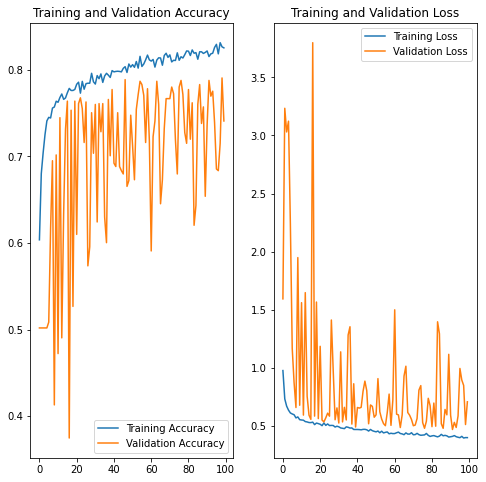

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
test_normal_path = "chest_xray/train/NORMAL/"
test_bacterial_path= "chest_xray/test/PNEUMONIA_BACTERIAL"
test_virus_path= "chest_xray/test/PNEUMONIA_VIRUS"

test_files_bacteria = [i for i in os.listdir(test_bacterial_path) if "bacteria" in i and path.isfile(path.join(test_bacterial_path, i))]
test_files_virus = [i for i in os.listdir(test_virus_path) if "virus" in i and path.isfile(path.join(test_virus_path, i))]
test_files_normal = [i for i in os.listdir(test_normal_path) if "NORMAL" in i and path.isfile(path.join(test_normal_path, i))]
img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



In [21]:
count = 0
for index in range(len(test_files_normal)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "NORMAL":
        count+=1

        
print("Accuracy for normal = ", count/len(test_files_normal) *100, "%")


Accuracy for normal =  97.87234042553192 %


In [22]:
count = 0
diagnosed = 0
for index in range(len(test_files_bacteria)):
    img = tf.keras.utils.load_img(
    path.join(test_bacterial_path, test_files_bacteria[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
    

print("Accuracy for bacterial pneumonia = ", count/len(test_files_bacteria) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_bacteria) *100, "%")

Accuracy for bacterial pneumonia =  95.86776859504133 %
Accuracy for pneumonia =  98.34710743801654 %


In [23]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  52.702702702702695 %
Accuracy for pneumonia =  99.32432432432432 %


In [24]:
!mkdir -p saved_model2
model.save('saved_model2/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [25]:
ls saved_model2/my_model

assets/            keras_metadata.pb  saved_model.pb     variables/


In [26]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)       

In [27]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  52.702702702702695 %
Accuracy for pneumonia =  99.32432432432432 %
